**DOCUMENT SCANNING PROJECT**


In [644]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys

In [645]:
image_path="input5.jpeg"

In [646]:
w, h = 480, 640

def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()


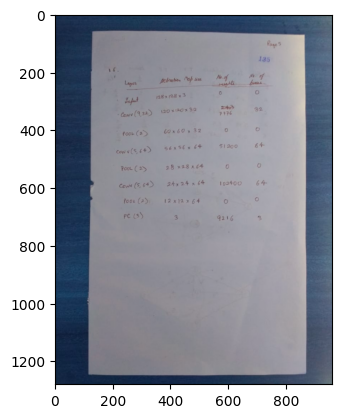

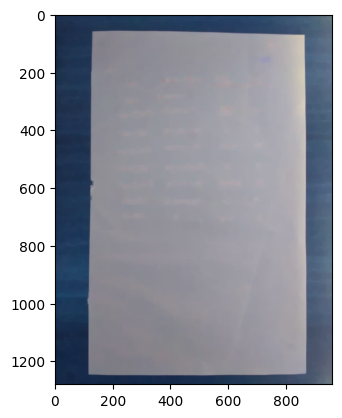

In [647]:
img = cv2.imread(image_path)
if img is None:
  print("File not Found")
img = cv2.resize(img, (960, 1280))
orig_img=img.copy()
plt.imshow(img)
plt.show()
# Repeated Closing operation to remove text from the document.
kernel = np.ones((5,5),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations= 3)
plt.imshow(img)
plt.show()

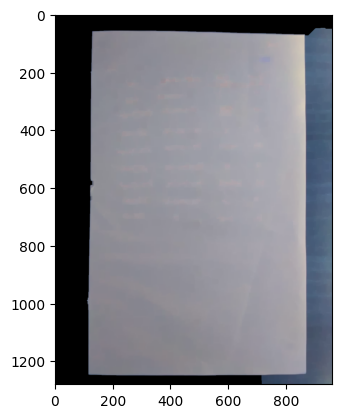

In [648]:
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (10,10,img.shape[1]-10,img.shape[0]-10)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
plt.imshow(img)
plt.show()

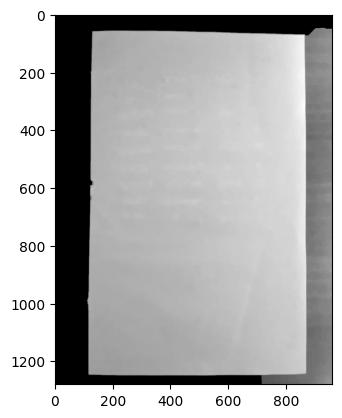

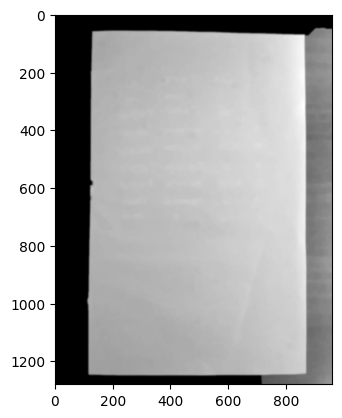

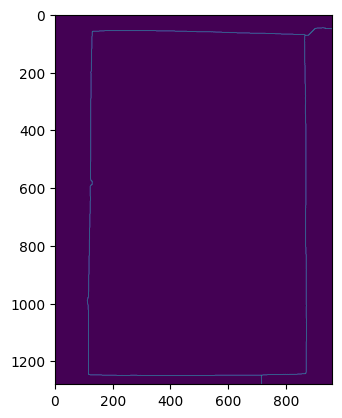

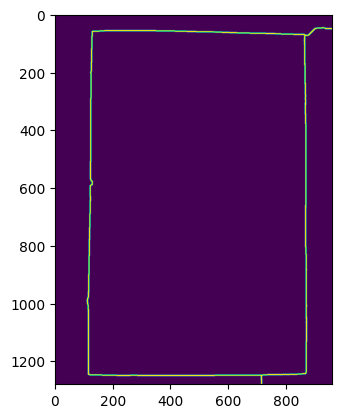

In [649]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()
gray = cv2.GaussianBlur(gray, (11, 11), 0)
plt.imshow(gray, cmap='gray')
plt.show()
# Edge Detection.
canny = cv2.Canny(gray, 0, 200)
plt.imshow(canny)
plt.show()
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
plt.imshow(canny)
plt.show()

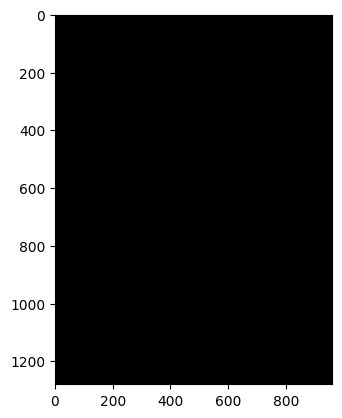

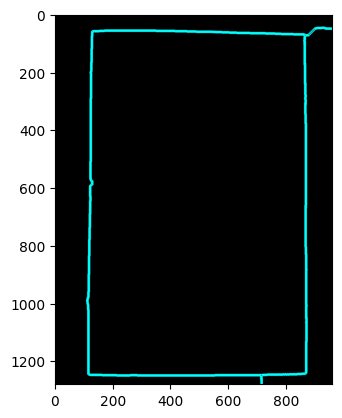

In [650]:
# Blank canvas.
con = np.zeros_like(img)
plt.imshow(con)
plt.show()
# Finding contours for the detected edges.
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the largest detected contour.
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)
plt.imshow(con)
plt.show()


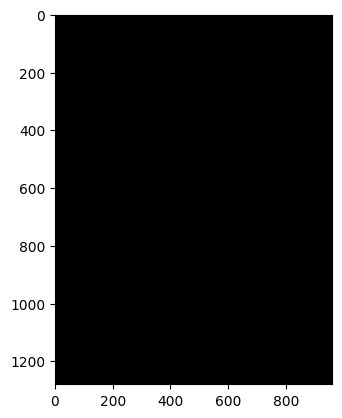

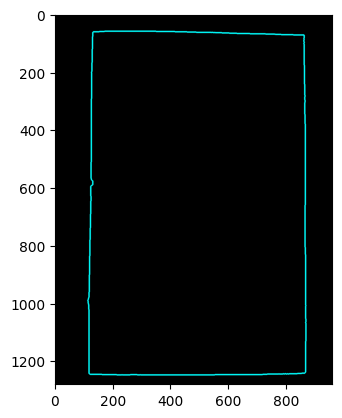

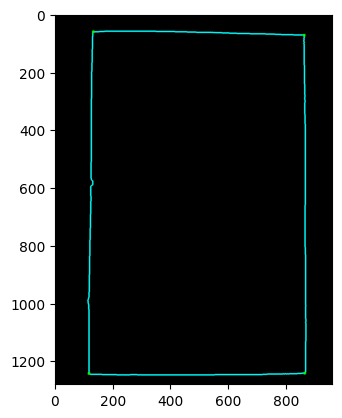

In [651]:
# Blank canvas.
con = np.zeros_like(img)
plt.imshow(con)
plt.show()
# Loop over the contours.
for c in page:
  # Approximate the contour.
  epsilon = 0.02 * cv2.arcLength(c, True)
  corners = cv2.approxPolyDP(c, epsilon, True)
  # If our approximated contour has four points
  if len(corners) == 4:
      break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
plt.imshow(con)
plt.show()
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
plt.imshow(con)
plt.show()

In [652]:
img.shape

(1280, 960, 3)

In [653]:
#sorting the corners based on manhattan distance from the edges
image_h=img.shape[0]
image_w=img.shape[1]
d= image_h+image_w
dtl=d
dtr=d
dbl=d
dbr=d

corners_temp = np.array(np.concatenate(corners).tolist())

for c in corners_temp:
  y=c[0]
  x=c[1]
  if dtl > (np.abs(x-0)/image_h + np.abs(y - 0)/image_w):
    dtl=np.abs(x-0)/image_h + np.abs(y - 0)/image_w
    tl_c=c

  if dtr > (np.abs(x-0)/image_h + np.abs(y - image_w)/image_w):
    dtr=np.abs(x-0)/image_h + np.abs(y - image_w)/image_w
    tr_c=c

  if dbl > (np.abs(x-image_h)/image_h + np.abs(y - 0)/image_w):
    dbl=np.abs(x-image_h)/image_h + np.abs(y - 0)/image_w
    bl_c=c

  if dbr > (np.abs(x-image_h)/image_h + np.abs(y - image_w)/image_w):
    dbr=np.abs(x-image_h)/image_h + np.abs(y - image_w)/image_w
    br_c=c    

  reordered_corners=np.array([tl_c, tr_c, br_c, bl_c])

In [654]:
tl_c

array([132,  61])

In [655]:
for c in reordered_corners:
  print(c)

[132  61]
[860  73]
[ 862 1242]
[ 117 1243]


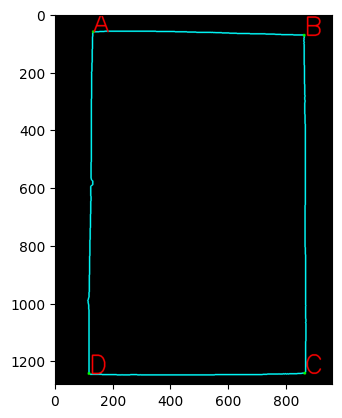

In [656]:
# Sorting the corners and converting them to desired shape.
#corners = sorted(np.concatenate(corners).tolist())


# Displaying the corners.
for index, c in enumerate(reordered_corners):
  character = chr(65 + index)
  cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(con)
plt.show()


In [657]:



#pts=order_points(corners)
(tl, tr, br, bl) = reordered_corners
# Finding the maximum width.
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
# Finding the maximum height.
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
# Final destination co-ordinates.
destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
print(destination_corners)


[[0, 0], [745, 0], [745, 1182], [0, 1182]]


In [658]:
print(corners)
print(reordered_corners)
print(destination_corners)

[[[ 132   61]]

 [[ 860   73]]

 [[ 862 1242]]

 [[ 117 1243]]]
[[ 132   61]
 [ 860   73]
 [ 862 1242]
 [ 117 1243]]
[[0, 0], [745, 0], [745, 1182], [0, 1182]]


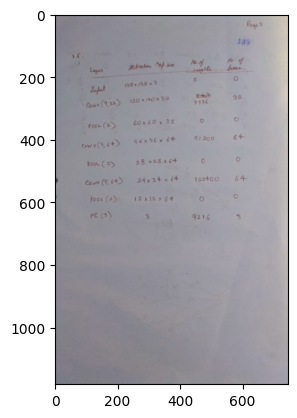

In [659]:
# Getting the homography.
M = cv2.getPerspectiveTransform(np.float32(reordered_corners), np.float32(destination_corners))
# Perspective transform using homography.
final = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)

plt.imshow(final)
plt.show()

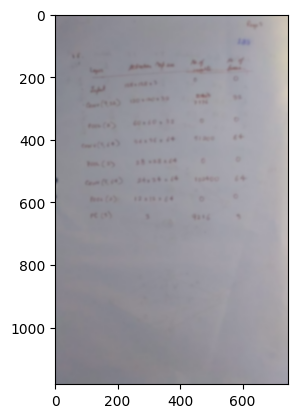

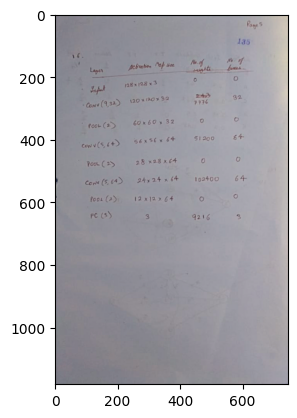

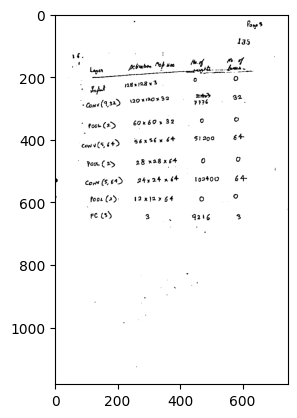

In [660]:
# sharpen image
sharpen = cv2.GaussianBlur(final, (0,0), 3)
plt.imshow(sharpen)
plt.show()
sharpen2 = cv2.addWeighted(final, 1.5, sharpen, -0.5, 0)
plt.imshow(sharpen2)
plt.show()
gray_f = cv2.cvtColor(sharpen2, cv2.COLOR_BGR2GRAY)
# apply adaptive threshold to get black and white effect
final_bw = cv2.adaptiveThreshold(gray_f, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)
plt.imshow(final_bw, cmap='gray')
plt.show()